# Final project: visualization of juice, milk,and sugar sweetened beverage intakes


  <font size= 5>
 <font color='red'>
 José Ángel Tinoco Carrillo
 </font> 
  </font> 

## AI use declaration
I did use AI in various parts of code of the project, all of such cases are specified in the commentary of the code.

## References and licenses

For this work, I used 3 datasets:
<br>
Juice, milk,and sugar sweetened beverage intakes- this dataset indicates the intake of the mentioned beverages by country and age range in 2010. It comes from the paper *Global, Regional, and National Consumption of Sugar-Sweetened Beverages, Fruit Juices, and Milk: A Systematic Assessment of Beverage Intake in 187 Countries* by Gitanjali M. Singh *et. al.*. The dataset is available within the article referenced below in pdf form. As for licenses, the article mentions in the copyright section that its whole contents are under a CC BY-4.0 license, meaning that they can be used as long as credit is given.
<br>
Reference: Singh, G. M., Micha, R., Khatibzadeh, S., Shi, P., Lim, S., Andrews, K. G., ... & Global Burden of Diseases Nutrition and Chronic Diseases Expert Group (NutriCoDE). (2015). Global, regional, and national consumption of sugar-sweetened beverages, fruit juices, and milk: a systematic assessment of beverage intake in 187 countries. PloS one, 10(8), e0124845.
<br>DOI:  https://doi.org/10.1371/journal.pone.0124845
<br><br>World map dataset - The second dataset was the json file which contained all the neccessary country geometries, and also some other useful data like the *continents* column. Said file was generated using the website https://geojson-maps.kyd.au/, which sources the maps from Natural Earth, which are in public domain, meaning those maps can be used for any purpose, and can even be used without attribution.
<br><br>GDP per capita - Lastly , I´m using the GDP per capita data from *THE WORLD BANK* , which lists a CC BY-4.0 license, meaning you can use the content for any purpose, as long as you give appropriate credit. Said data was retrieved in csv form from https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?view=map&year=2022.
<br><br>For further reference, here are the terms of the CC BY-4.0 license: https://creativecommons.org/licenses/by/4.0/
<br> <br>
Given the criteria above, it can be concluded that the datasets can be used for the present project, because the map data is public domain (no attribution needed), and the other 2 are CC BY-4.0 licenses, meaning I only need to give attribution to the original authors, as I have done above.

## Data cleaning and preparation

Extensive work must be done to prepare the data for analysis, as the main dataset is presented in pdf format. Therefore, data must be extracted from said file, and carefully adapted to allow later merges with the map and GDP per capita datasets.

In [1]:
#Import neccesary modules. 
import tabula
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import ListedColormap
import statsmodels.api as st
import matplotlib.animation as animation
from IPython.display import Image, display
import warnings
sns.set_style('whitegrid')
pd.options.mode.chained_assignment = None 

In [2]:
#Read the pdf file using the tabula module, AI helped in learning to use the tabula library.
#This a direct reading of the pdf file.
tables = tabula.read_pdf( "datasets/S1_File.pdf", pages='18-45', multiple_tables=True)

In [3]:
#I included all the tables in a list to process them further.
table_list = []
for table in tables:
    table_list.append(table)

#The column titles were read as the first rows, so I join those rows and rename the columns appropriately, AI helped.
for i, table in enumerate(table_list, start=1):
    new_column_names = table.iloc[:4].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=0)
    table.columns = new_column_names

In [4]:
#Declare new tables skipping the first rows, as these rows were the column titles.
new_tables = []
for i in range(len(table_list)):
    new_table = table_list[i].iloc[6:]
    new_table_name = f"new_table_{i}"
    locals()[new_table_name] = new_table
    new_tables.append(new_table)

In [5]:
#Paste together all the tables and drop NA values.
#For context, some country names were too long, and ended up on 2 rows, one with half of the country name and NAs, and a second row with the other part of the country name
# and the corresponding values for said country; for example, 'Democratic Republic of the' ended up on a row as country name, and the rest of the row were NAs , while a second row had 'Congo' on country name ,
# and that row contained all the relevant values.
#This way, I can cut all NA rows, and later fix the broken country names.
concatenated_table = pd.concat(new_tables, ignore_index=True)
concatenated_table = concatenated_table.dropna()

In [6]:
#Manual fix to an unexpected issue caused by the code above. Both the 'Democratic Republic of the Congo' and 'Republic of the Congo' got shortened to 'Congo', which cause an issue later on.
#Similarly, both 'Democratic People's republic of Korea', and 'Republic of Korea' got shortened to 'Korea', so that case also needed manual fixing.
concatenated_table.loc[491:517, 'Country'] = 'Democratic Republic of the Congo'
concatenated_table.loc[1961:1987, 'Country'] = 'North Korea'

In [7]:
#Fixing of all the shortened names and adapting some others for merging datasets down the line.
inaccurate_names=['Congo','Micronesia (Federated',"Lao People's Democratic",'Macedonia (Former',"Democratic People's",'Occupied Palestinian','Venezuela (Bolivarian','Grenadines','Republic of)',
                   'States of)','Republic','Yugoslav Republic of)','Territory','Russian Federation','Libyan Arab Jamahiriya','Czech Republic','Viet Nam','Republic of Korea',"Lao People's Democratic Republic",
                   'Iran (Islamic Republic of)',"Côte d'Ivoire",'Serbia','Syrian Arab Republic','Brunei Darussalam','São Tomé and Príncipe','Swaziland','Bahamas']
actual_names=['Republic of the Congo','Micronesia','Laos','North Macedonia','North Korea','Occupied Palestinian Territory',
              'Venezuela','Saint Vincent and the Grenadines','Venezuela','Federated States of Micronesia','Laos','North Macedonia','Palestine','Russia','Libya','Czechia','Vietnam','South Korea','Laos','Iran',
              'Ivory Coast','Republic of Serbia','Syria','Brunei','São Tomé and Principe','eSwatini','The Bahamas']
country_mapping = dict(zip(inaccurate_names, actual_names))
concatenated_table['Country'] = concatenated_table['Country'].replace(country_mapping) #AI helped.


In [8]:
#Selecting the relevant columns.
Dataset=concatenated_table[['Country','Sex','Midpoint of age range','Mean juice intake','Mean milk intake','Mean SSB intake (servings/day)']]

In [9]:
#Fixing column names and setting correct data types.
Dataset.columns = ['Country','Sex','Midpoint_of_age_range','juice_intake','milk_intake','SSB_intake']
Dataset['juice_intake'] = Dataset['juice_intake'].astype(float)
Dataset['milk_intake'] = Dataset['milk_intake'].astype(float)
Dataset['SSB_intake'] = Dataset['SSB_intake'].astype(float)
Dataset['Midpoint_of_age_range'] = Dataset['Midpoint_of_age_range'].astype(float)

In [10]:
#Getting mean data by country.
mean_data = Dataset.groupby('Country')[['juice_intake', 'milk_intake', 'SSB_intake']].mean().reset_index()

In [11]:
#Creating a few extra rows due to border mismatch , at the time of the original beverage intake paper, Sudan and South Sudan were same country, same case for Somalia and Somaliland.
#Gave Greenland same data as Denmark (Greenland is governed by Denmark).
south_sudan = mean_data[mean_data['Country'] == 'Sudan']
south_sudan['Country'] = 'South Sudan'
greenland = mean_data[mean_data['Country'] == 'Denmark']
greenland['Country'] = 'Greenland'
somaliland = mean_data[mean_data['Country'] == 'Somalia']
somaliland['Country'] = 'Somaliland'
mean_data = pd.concat([mean_data, south_sudan, greenland, somaliland])

In [12]:
# Load the JSON file using GeoPandas.
#Made no changes to the file, only changed name.
world = gpd.read_file('datasets/countries.json')


In [13]:
#Do a left merge of the map data with the mean data; this keeps all the countries from the map data 'admin' column, and then I drop all entries that didn´t find a match during the merge. 
# I tried to match the 'Country' column of the beverages dataset to the 'admin' column of the map dataset, the latter column has shortened country names,
# but the data preparation done before ensures a good merge between the two dataframes.
merged= pd.merge(world, mean_data, left_on='admin', right_on='Country', how='left')
merged.dropna(subset=['Country'], inplace=True)

In [14]:
# Load the GDP per capita dataset.
#Made no changes to the file, only changed name.
gdp = pd.read_csv('datasets/GDP.csv', skiprows=4)

In [15]:
#Perform a left merge of the merged dataset with the GDP per capita dataset.
#The 'Country code' column of the gdp dataset provides a perfect match to the 'adm0_a3' column of the merged dataset, as said column has pretty much the same country codes.
merged2=pd.merge(merged, gdp, left_on='adm0_a3', right_on='Country Code', how='left')

In [16]:
#From the mean data, get the top 10 countries with the highest sugar sweetened beverage intake, get all the data of said countries from the original dataset, and subset said data by sex.
top_10 = mean_data.sort_values(by='SSB_intake', ascending=False)
top_10=top_10[:10]
top_10 = top_10['Country'].tolist()  
top_10= Dataset[Dataset['Country'].isin(top_10)] #AI helped get the corresponding data from the  'Dataset' dataframe.
top_10=top_10[['Country','Sex','Midpoint_of_age_range','SSB_intake']]
male_top_10 = top_10[top_10['Sex']=='M']
female_top_10= top_10[top_10['Sex']== 'F']

In [17]:
#Generate and add a 'World' average for each age to the male top 10 dataframe.
male_world_SSB = Dataset[Dataset['Sex']=='M'].groupby('Midpoint_of_age_range')[['SSB_intake']].mean().reset_index()
male_world_SSB['Country']='World'
male_world_SSB['Sex']='M'
male_top_10=pd.concat([male_top_10,male_world_SSB])

In [18]:
#Generate and add a 'World' average for each age to the female top 10 dataframe.
female_world_SSB = Dataset[Dataset['Sex']=='F'].groupby('Midpoint_of_age_range')[['SSB_intake']].mean().reset_index()
female_world_SSB['Country']='World'
female_world_SSB['Sex']='F'
female_top_10=pd.concat([female_top_10,female_world_SSB])

## Basic-plot task

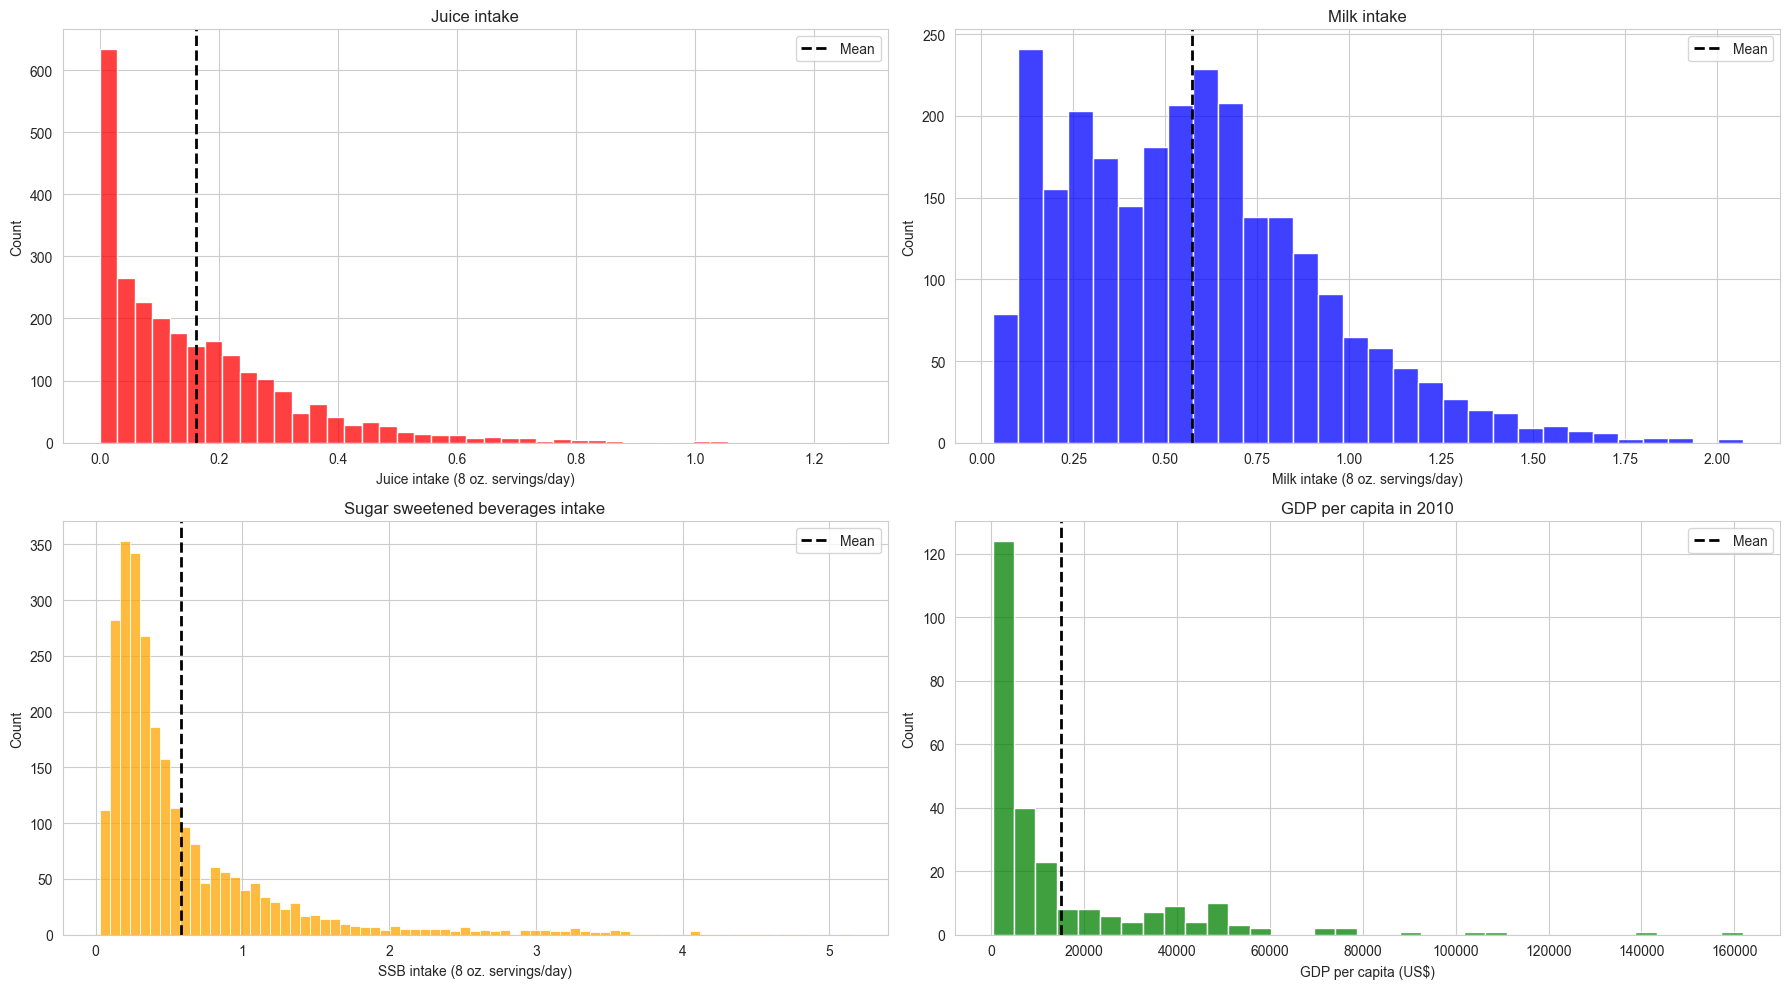

In [19]:
#Generated a histogram for every numerical variable in my datasets.
#The most relevant numerical variables in the beverages dataset were juice intake, milk intake and sugar-sweetened beverages intake.
#The map dataset didn´t contain numerical variables.
#The GDP per capita dataset contains said metric in several different years. However, the GDP per capita for 2010 is the only relevant one, because the info presented in the beverages dataset corresponds to 2010.
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(18, 10))
numeric_variables=['juice_intake','milk_intake','SSB_intake']
labels=['Juice intake (8 oz. servings/day)','Milk intake (8 oz. servings/day)','SSB intake (8 oz. servings/day)']
colors=['red','blue','orange']
titles=['Juice intake','Milk intake','Sugar sweetened beverages intake']
for variable,ax,label,color,title in zip  (numeric_variables,[ax1,ax2,ax3],labels,colors,titles):
    sns.histplot(ax=ax,data=Dataset,x=variable,color=color)
    mean=Dataset[variable].mean()
    ax.axvline(x=mean,color='black',linewidth=2,linestyle='--',label='Mean')
    ax.set_xlabel(label)
    ax.legend()
    ax.set_title(title)
sns.histplot(ax=ax4,data=gdp,x='2010',color='green')
mean=gdp['2010'].mean()
ax4.axvline(x=mean,color='black',linewidth=2,linestyle='--',label='Mean')
ax4.legend()
ax4.set_xlabel('GDP per capita (US$)')
ax4.set_title('GDP per capita in 2010')
plt.tight_layout()

*Figure 1.* Histogram plots of the most relevant numerical variables: juice intake, milk intake, sugar sweetened beverage intake, and GDP per capita in 2010. Beverage intake surveys were carried out in 2010, so GDP per capita for that year was chosen. On all beverage categories, the values tend to be on the left of the graph, meaning that overall, people worldwide don't drink much juice, milk, or sugar-sweetened beverages, drinking less than an 8-ounce serving of each of them per day. The GDP per capita plot shows that most countries have sub 20000 US$ GDPs per capita, and that there are very few countries on the higher end of said measure.

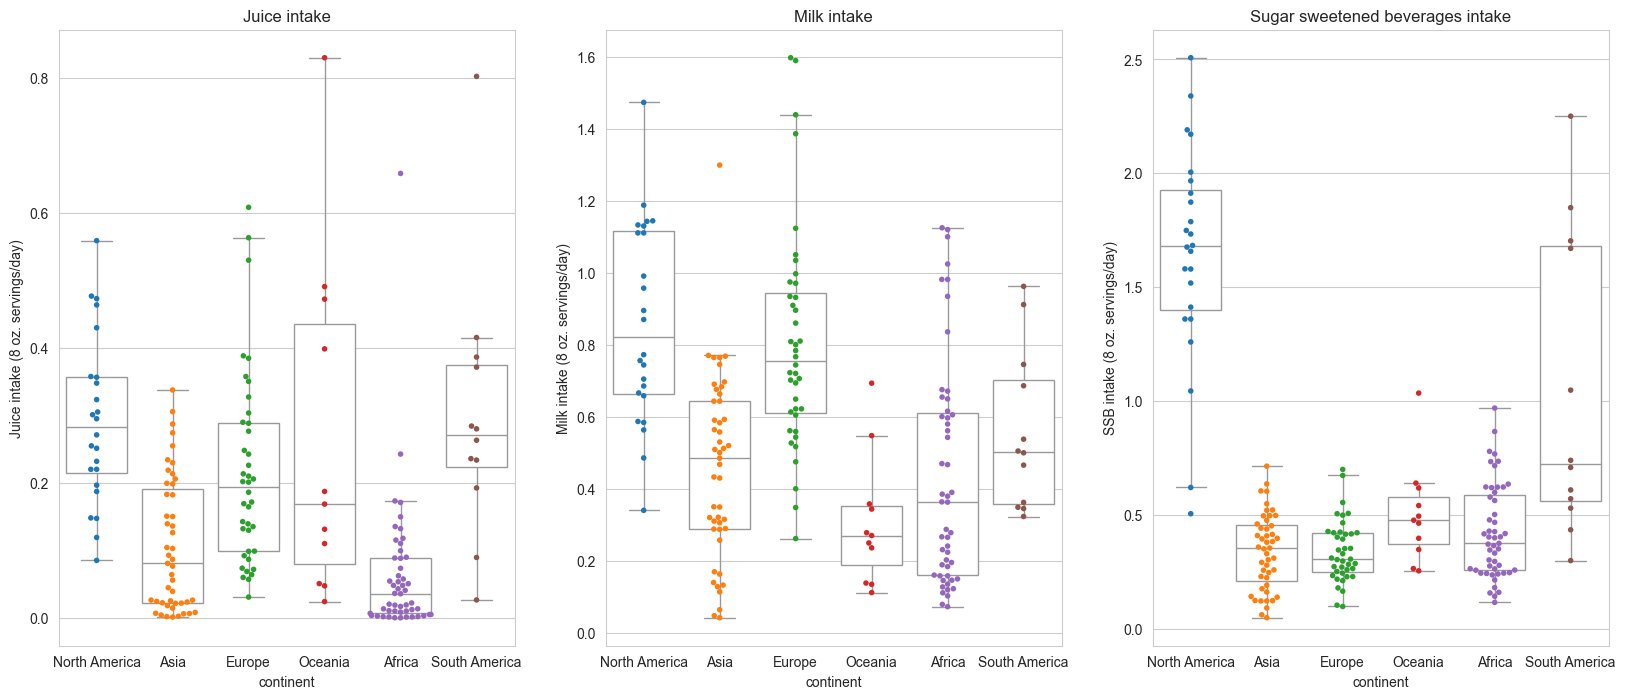

In [20]:
#Generate boxplots overlaid with swarmplots.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
for variable,ax,title,label in zip  (numeric_variables,[ax1,ax2,ax3],titles,labels):
    sns.swarmplot(ax=ax,data=merged, x='continent', y=variable,size=4,hue='continent')
    sns.boxplot(ax=ax,data=merged, x='continent', y=variable, color='white',showfliers=False)
    ax.set_ylabel(label)
    ax.set_title(title)

*Figure 2.* Boxplots overlaid with swarm plots of juice intake, milk intake, and sugar-sweetened beverages intake. The spread, density, and outliers of datapoints are visible in the plots. In all three categories of drinks, North America exhibits the highest median values.

### Interpretation

Juice intake : It can be observed that North America has the highest median juice consumption value , while Asia and Africa boast the lowest medians. Another interesting observation from these graphs is the distribution of the values, Asia's and Africa's data points cluster at the bottom of the graph, while the rest of the continents have more balanced distributions.

Milk intake:  This time, North America and Europe have the biggest median values, while Oceania and Africa exhibit the lowest median value.

Sugar-Sweetened Beverages intake: It is evident how North America has the biggest intakes of this type of beverages by a huge margin. Something else noteworthy about this graph might be the wide range of values in South America.


A quick conclusion from these graphs might be that North America is leading in consumption of non-alcoholic beverages of all types, which could have ill effects in the health of the populations of those countries. Contrary to that, Asia and Africa boast some of the lowest values for all three kinds of drinks, so that could be beneficial to those populations, as less sugar intake is healthy.

## Scatterplot task

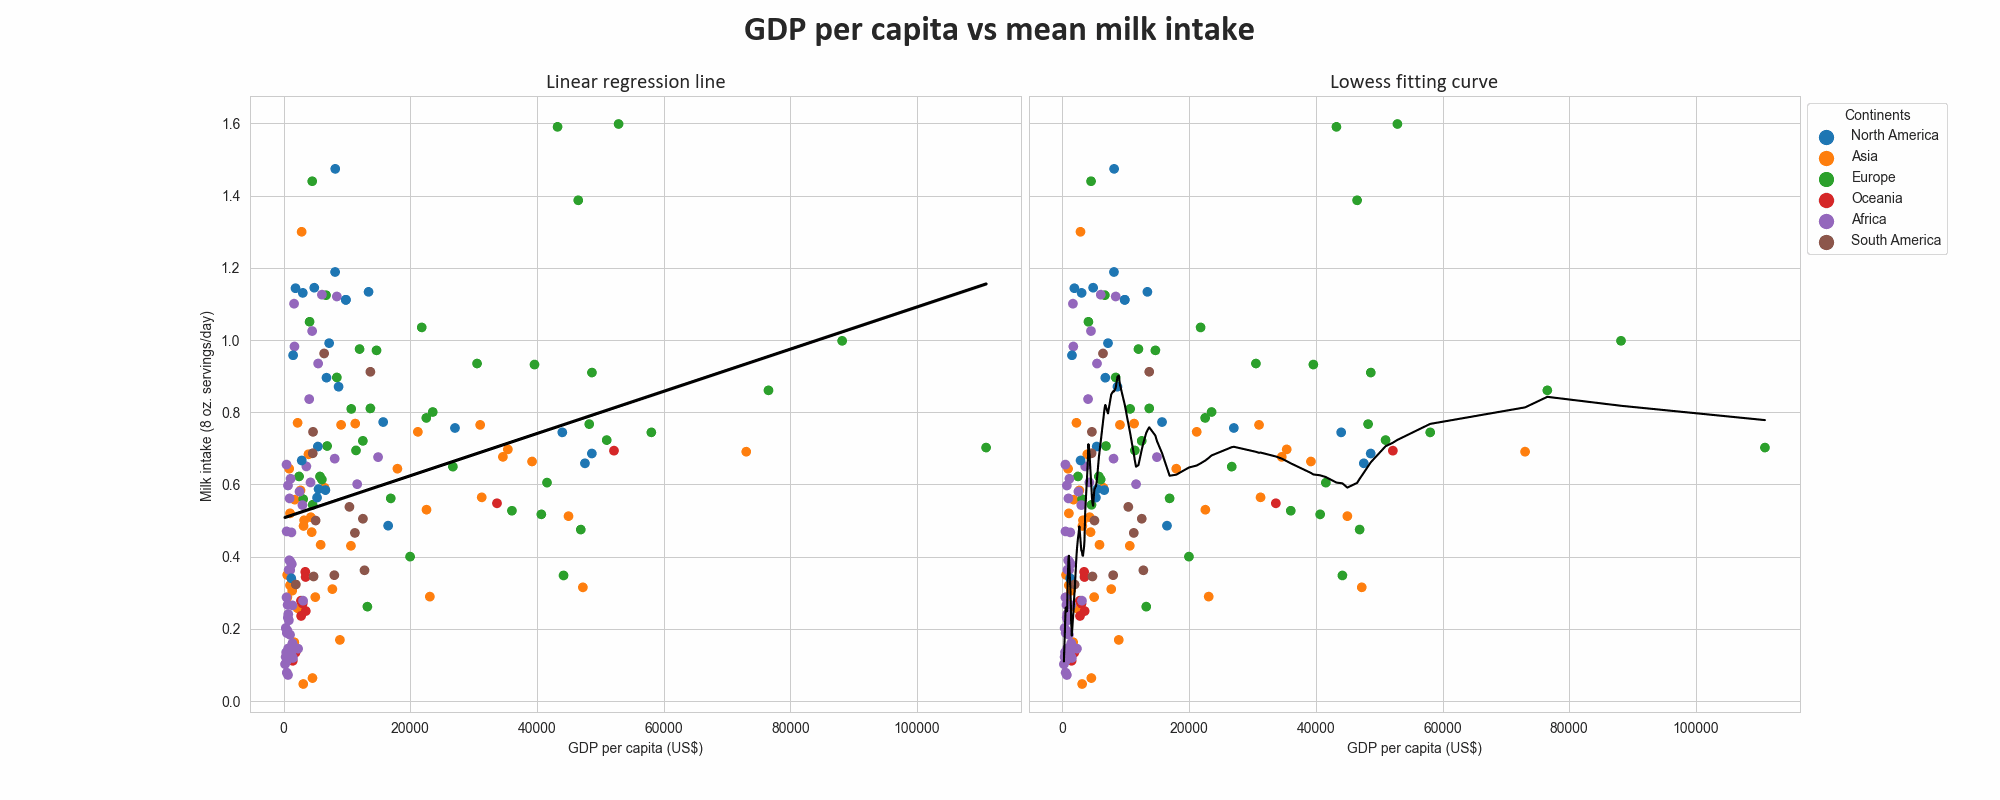

In [21]:
#For this task, I got the idea of doing a scatterplot of GDP per capita vs mean milk intake, and coloring the data points by continent.
#To compare and contrast the difference between linear regression lines and lowess fitting curves, I made an animation where the data points slowly fade, revealing the best fit line/ lowess regression curve behind.
#AI helped learn the matplotlib animation module.
x = merged2['2010']
y = merged2['milk_intake']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True, gridspec_kw={'wspace': 0.01})

#Initialize the plots; I make the line of best fit and lowess fitting curve separately from the scatterplots, 
#because I only want to change the transparency of the points of the scatterplots, and leave the best fit line/lowess fitting curve intact.
sns.regplot(ax=ax1, x=x, y=y, scatter_kws={'alpha': 0}, ci=None, line_kws = {'color': 'black'})
scatter1 = ax1.scatter(x, y, c=merged2['continent'].map(dict(zip(merged2['continent'].unique(), sns.color_palette()))), alpha=1)
lowess_result = st.nonparametric.lowess(exog=x, endog=y, frac=0.1)
line2, = ax2.plot(lowess_result[:, 0], lowess_result[:, 1], label='LOWESS Curve',color='black')
scatter2 = ax2.scatter(x, y, c=merged2['continent'].map(dict(zip(merged2['continent'].unique(), sns.color_palette()))), alpha=1)
ax1.set_ylabel('Milk intake (8 oz. servings/day) '), ax1.set_xlabel('GDP per capita (US$)'), ax1.set_title('Linear regression line',weight='bold', font = 'calibri', fontsize= 15)
ax2.set_xlabel('GDP per capita (US$)'), ax2.set_title('Lowess fitting curve',weight='bold', font = 'calibri', fontsize= 15)
fig.suptitle('GDP per capita vs mean milk intake',weight='bold', font = 'calibri', fontsize= 25)

# Create a legend for the continents
continent_colors = dict(zip(merged2['continent'].unique(), sns.color_palette()))
continent_handles = [plt.scatter([], [], s=100, color=color, label=continent) for continent, color in continent_colors.items()]
ax2.legend(handles=continent_handles, loc='upper left', title='Continents', bbox_to_anchor=(1, 1))

# Update function for the animation
#This function lowers the transparency of the scatterplot points every frame until they are completely transparent.
def update(frame):
    alpha = 1 - (frame / 100)  # Calculate alpha based on the frame number
    scatter1.set_alpha(alpha)  # Set alpha for the scatter plots
    scatter2.set_alpha(alpha)
    return scatter1, scatter2

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=100, interval=50, blit=True)

# Save the animation as a GIF file
ani.save('scatterplot_animation.gif', writer='pillow')
plt.close(fig)

display(Image(filename='scatterplot_animation.gif'))

*Figure 3.* Scatterplots of GDP per capita vs mean milk intake, with linear regression line and lowess fitting curve. As a country's GDP per capita increases, so does milk consumption. Both models tell the same general story, and each model has its own advantages and disadvantages, linear regression is useful for prediction and describing general trends, while lowess fitting curves are better at describing the nuances in the data. 

### Regression line vs lowess fitting curve
While both the regression line and the lowess fitting curve both tell the same general story that as GDP per capita increases, so does milk consumption, the lowess fitting curve paints a clearer and more detailed picture. The lowess fitting curve shows that once a people's GDP per capita rises, a sharp immediate rise in milk intake follows, and then fluctuate , and plateau after GDP  per capita exceeds 60000 US$ . The reasons for this are clear: milk is a desireable drink, as it is a very complete drink, that brings nourishment for people of all ages, so once people experience economic development, they quickly pick it as their drink of choice. All of these extra details are absent from the linear regression line. Another reason for picking the lowess fitting curve is that we are not trying to predict data, we are only trying to describe it. If we were trying to predict data outside of our range, then the linear regression line would be very useful, as said model presents a simple equation, which can predict values beyond the original data range. However, since our purpose is describing the data, a lowess regression curve is better.
### Interpretation
From the graph we can observe the general trends of milk consumption ;as mentioned above, the general trend is that higher GDP per capita corresponds to increased milk intake. We can also observe the general socioeconomic status of the countries in each continent: Africa & South America have GDPs per capita below 20000 US$ ,other continents have more spread out values, and the absolute highest GDPs per capita are found in Europe.

## Animation task

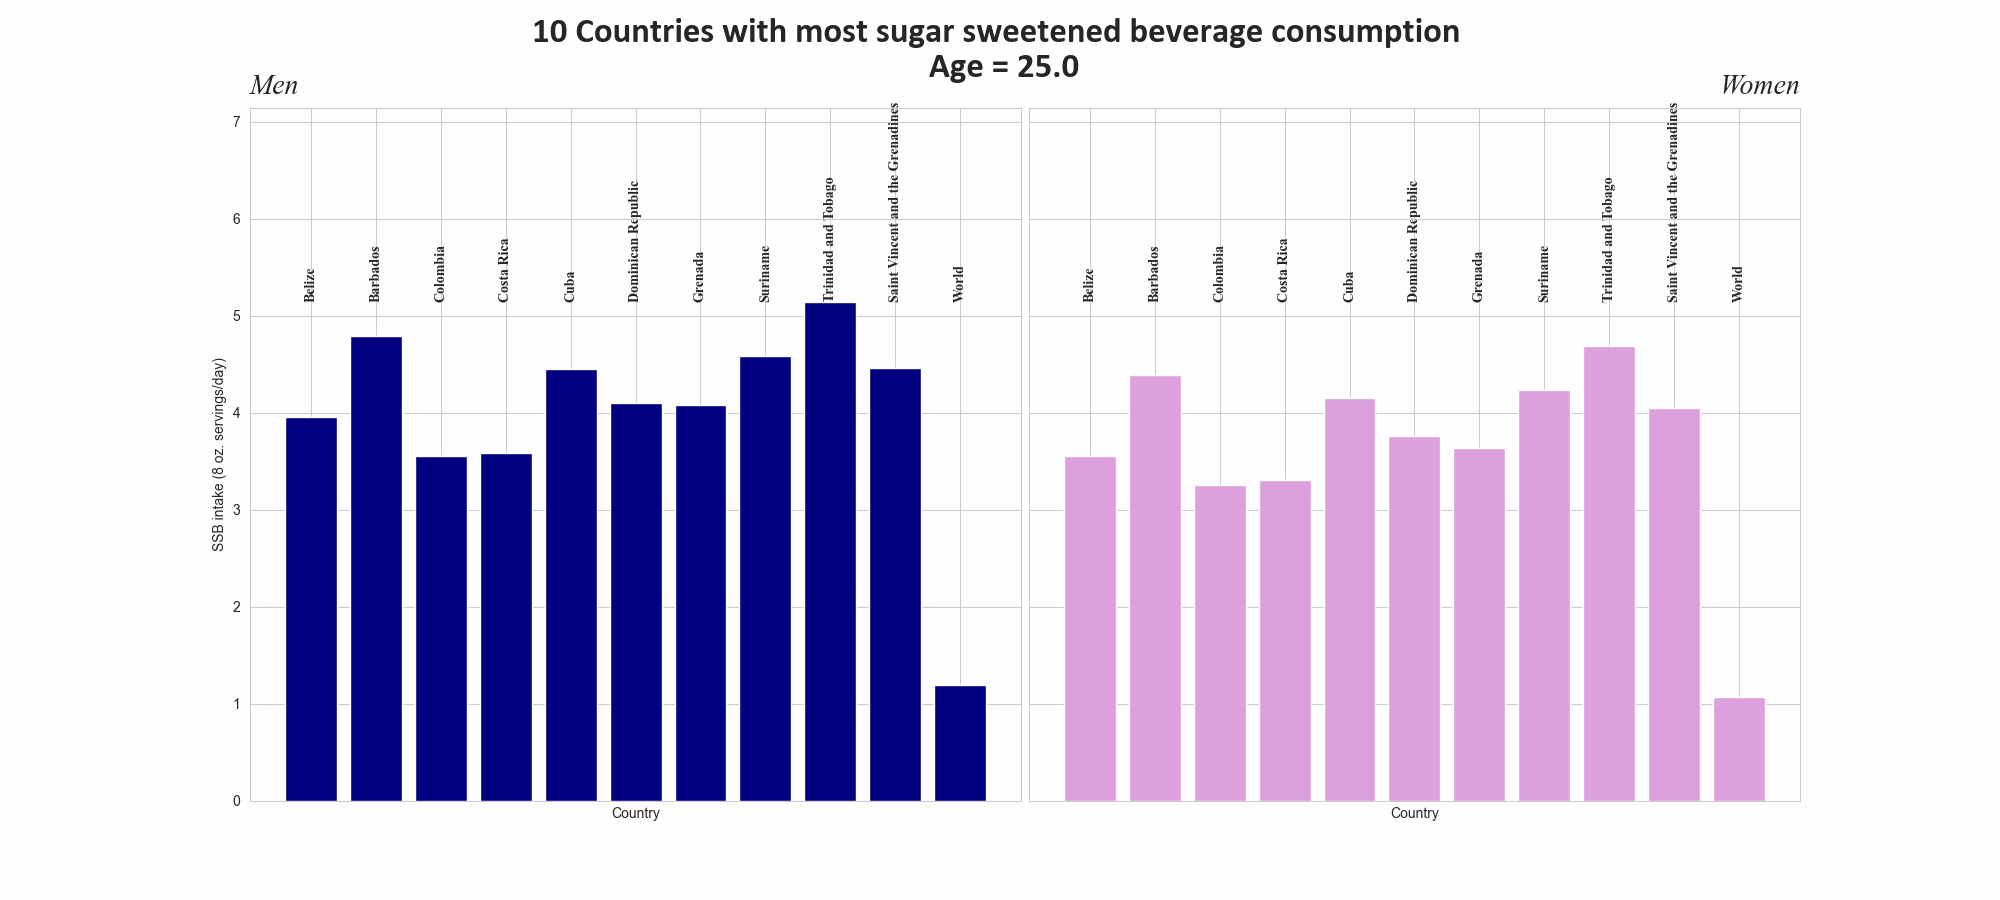

In [22]:
#Once again, AI helped get the animation going.
#Get all unique ages.
ages = top_10['Midpoint_of_age_range'].unique()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9), sharey=True, gridspec_kw={'wspace': 0.01})
# Initialize empty bar plots
bar_plot1 = ax1.bar([], [])
bar_plot2 = ax2.bar([], [])
# Update function for the animation
#It changes the data by age every frame.
def update(frame):
    age = ages[frame]
    subset1 = male_top_10[male_top_10['Midpoint_of_age_range'] == age]
    subset2 = female_top_10[female_top_10['Midpoint_of_age_range'] == age]
    fig.suptitle(f'10 Countries with most sugar sweetened beverage consumption \n Age = {age}', font='Calibri', weight= 'bold', size= 25)
    ax1.clear() ,ax2.clear()    # Empty out the axes, so that bars from previous frames are not shown.
    ax1.set_title('Men', loc= 'left',font='Times new roman', style= 'italic', size= 20)
    ax2.set_title('Women', loc = 'right',font='Times new roman', style= 'italic', size= 20)
    #There was a problem because the country names were too long, so there was no way to fit them at the bottom, even at an angle, so the solution I did was having them at the top of the plot,
    # and leaving space for them within the plot, making them 'waterfall' from the top of the graph.
    ax1.set_ylim(0, (top_10['SSB_intake'].max())+2), ax2.set_ylim(0, (top_10['SSB_intake'].max())+2) # 
    bar_plot1 = ax1.bar(subset1['Country'], subset1['SSB_intake'], color= 'navy')
    bar_plot2 = ax2.bar(subset2['Country'], subset2['SSB_intake'], color= 'plum')
    ax1.set_xlabel('Country'), ax2.set_xlabel('Country')
    ax1.set_ylabel('SSB intake (8 oz. servings/day)')
    #AI helped get the code needed to make country labels be in the upper part of the graph, rotated 90°, and also within the plot. 
    ax1.tick_params(labeltop=True, bottom=False, labelbottom=False, axis='x', rotation=90, size=22, direction='in', pad=-140)
    ax2.tick_params(labeltop=True, bottom=False, labelbottom=False, axis='x', rotation=90, size=22, direction='in', pad=-140)
    for label in ax1.get_xticklabels():
        label.set_font('Times new roman')
        label.set_weight('bold')
    for label in ax2.get_xticklabels():
        label.set_font('Times new roman')
        label.set_weight('bold')
    return bar_plot1 + bar_plot2
# Create the animation using ArtistAnimation
ani = animation.FuncAnimation(fig, update, frames=len(ages), interval=2000, blit=True)
# Save the animation as a GIF file
ani.save('age_bar_plots.gif', writer='pillow')
plt.close(fig)
# Display the animation
display(Image(filename='age_bar_plots.gif'))

*Figure 4.* Animation of the 10 countries with highest mean sugar-sweetened beverage consumption, split by age and sex. The animation illustrates that, in general, men drink more sugar sweetened beverages, and that consumption of such products is driven most by young people, with consumption falling off as people age.

### Animation interpretation
Animation has clear advantages. The main advantage highlighted is that the animation serves as a form of 'dimensionality reduction', because the same information can be expressed in a lineplot , however, such plot would have many different lines (one per country) with very close values between each of them, so while the same message would still be conveyed, doing it through an animation provides a much more beautiful and intuitive way to understand the data. While seeing the curves go downward in a lineplot like the one mentioned above can give the message needed, seeing the bar drop with each age in the animation above is a much more direct and intuitive way to deliver the message: even in the countries that most consume sugar-sweetened beverages , such consumption is driven mostly by younger people, with consumption diminishing as people age. 

## Reproduce-plot

This is the figure from the paper that I set out to reproduce:

<center> <img style="padding: 10px;" src="https://journals.plos.org/plosone/article/figure/image?size=large&id=10.1371/journal.pone.0124845.g001" width="800"> </center>

(Singh *et. al.*, 2015)

In [23]:
#I made a function to plot in the map all the data of Milk, Juice and Sugar-sweeted beverage consumption.
#This function accepts 4 arguments, column (the attribute to plot), the axis on which to plot, reverse (whether or not to reverse color palette), & text (text to put on the plot).
#AI helped make the colorbar legend be at the bottom of the plots, and also to ignore a warning of one packages.
def plot_map (column,ax,reverse,text):
    #To make the color palette similar to the paper, I got a section of the nipy_spectral color palette.
    start_color = 0.2 
    end_color = 0.9        
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='The get_cmap function was deprecated')
        cmap_section = plt.cm.get_cmap('nipy_spectral')(np.linspace(start_color, end_color, 24))
    cmap_section = ListedColormap(cmap_section)
    #On the paper, the color palette for the milk consumption plot is the same one as the others, but reversed.
    if reverse == True:
        cmap_section=cmap_section.reversed()
    max_value = merged[column].max()
    min_value = merged[column].min()
    # Plot the values
    merged.plot(column=column, cmap=cmap_section, ax=ax, vmin=min_value, vmax=max_value)
    # Remove the axis labels
    ax.set_axis_off()

    # AI helped with the code below, it makes a horizontal color bar and sets it to be on the bottom of the plot.
    ticks = np.linspace(min_value, max_value, 8)
    sm = plt.cm.ScalarMappable(cmap=cmap_section, norm=plt.Normalize(vmin=0, vmax=max_value))
    sm.set_array([])
    #Add the color bar
    cbar = plt.colorbar(sm, ax=ax, fraction=0.04, pad=-0.05, orientation='horizontal')
    # Set the tick positions and labels
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick:.2f}' for tick in ticks])
    # Set the tick parameters
    cbar.ax.tick_params(direction='out', length=8, width=1, color='black', labelsize=12)
    cbar.ax.text(1.05, 0.5, '8 oz. servings/day', transform=cbar.ax.transAxes, va='center', weight = 'bold')
    ax.text(0.05, 0.3, text, transform=ax.transAxes, va='center', weight= 'bold', size = 20)

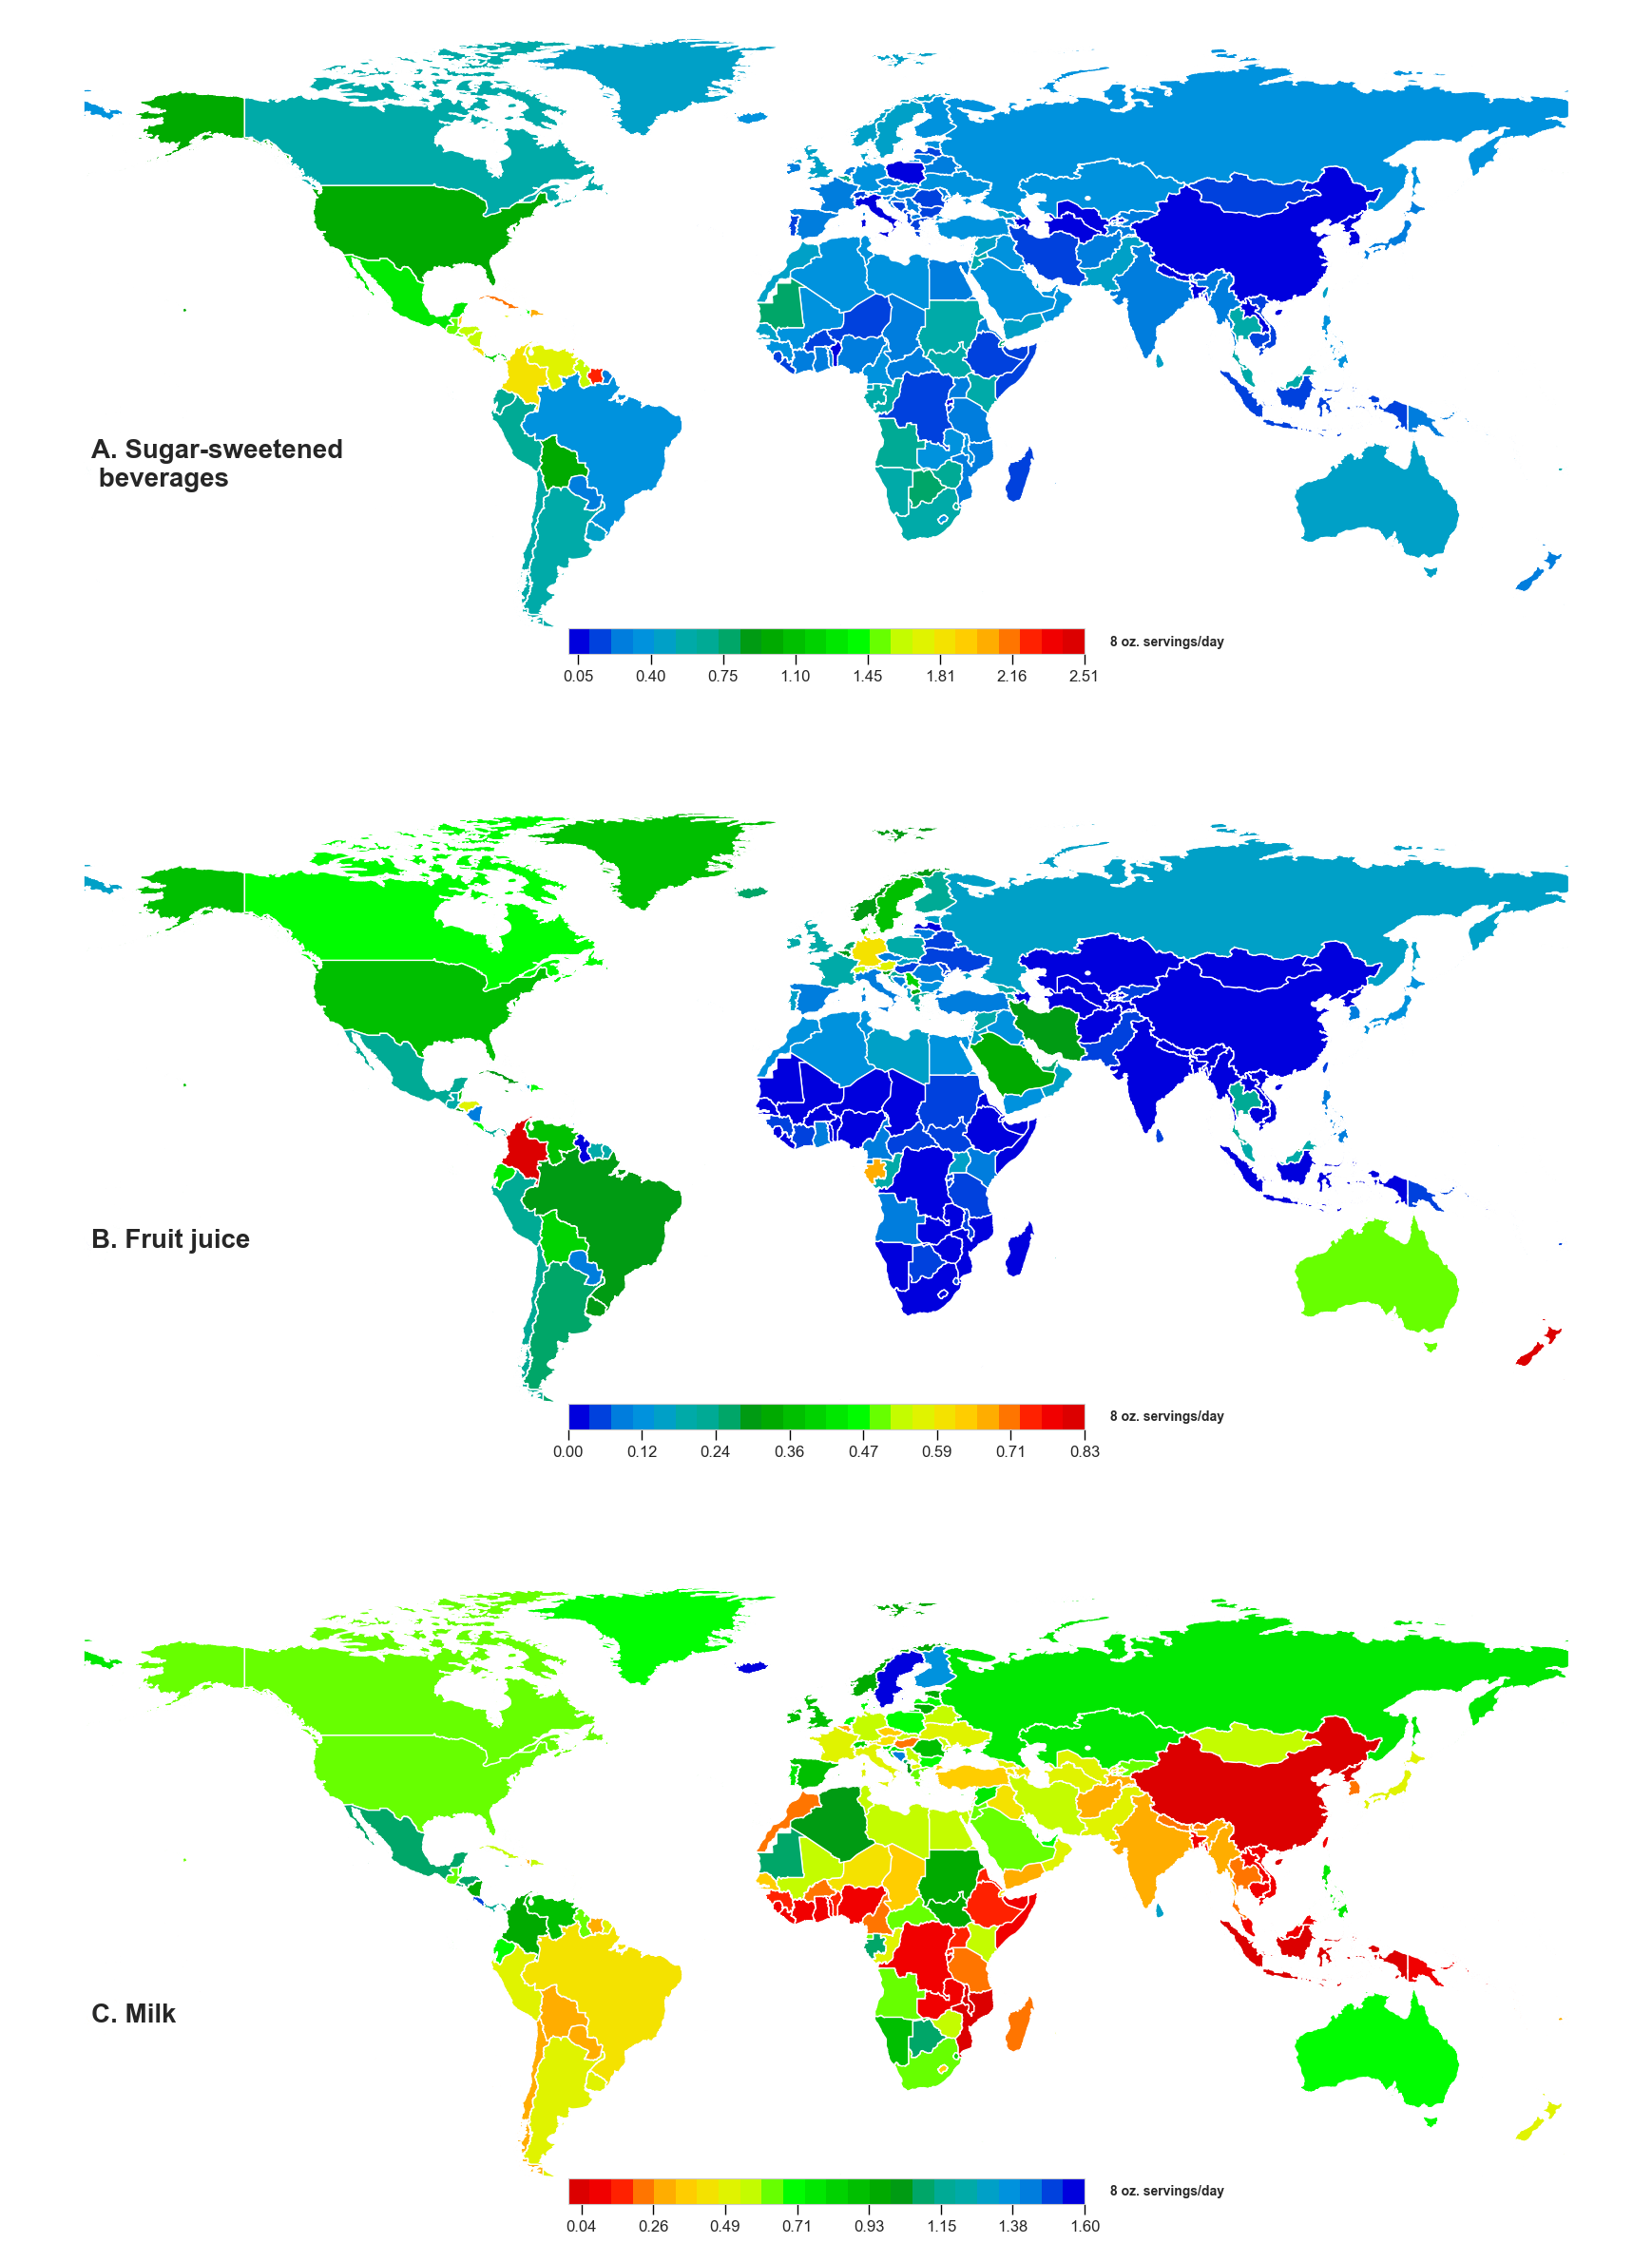

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 30))
#Use the function above to make the 3 neeeded plots.
plot_map('SSB_intake',ax1,False,'A. Sugar-sweetened \n beverages ')
plot_map('juice_intake',ax2,False,'B. Fruit juice')
plot_map('milk_intake',ax3,True,'C. Milk')
# Show the plot
plt.show()
fig.savefig('map.jpg', format='jpeg')


*Figure 5.* Consumption of sugar-sweetened beverages, juice & milk mapped worldwide. The map highlights that Eastern Asia & Africa have low levels of consumption in all 3 beverages, while North America & Central America show high levels of consumption in all 3.